# Transcriptomic Clustering

In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import transcriptomic_clustering as tc 

## Loading data

In [2]:
tasic_adata = sc.read_h5ad('./data/tasic2016counts_sparse.h5ad',backed='r')
print(tasic_adata)


AnnData object with n_obs × n_vars = 1809 × 24057 backed at 'data/tasic2016counts_sparse.h5ad'


## Normalize

In [3]:
normalized_adata = tc.normalize(tasic_adata,copy_to='./data/normalized5.h5ad')
print(normalized_adata)


processing: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

AnnData object with n_obs × n_vars = 1809 × 24057 backed at 'data/normalized5.h5ad'


## Highly Variant Genes

In [4]:
means, variances, gene_mask = tc.get_means_vars_genes(adata=normalized_adata)
tc.highly_variable_genes(adata=normalized_adata, 
                         means=means, variances=variances, 
                         gene_mask=gene_mask, max_genes=3000)
print(normalized_adata)

AnnData object with n_obs × n_vars = 1809 × 24057 backed at 'data/normalized5.h5ad'
    var: 'highly_variable'
    uns: 'hvg'


## PCA

In [5]:
(components, explained_variance_ratio, explained_variance, means) = \
    tc.pca(normalized_adata, n_comps=25, cell_select=1000, use_highly_variable=True, svd_solver='arpack')
print(components.shape)

(3000, 25)


## Filter Known Modes

In [6]:
known_modes = components[[24]] # select last component as a known mode as an example
components = tc.filter_known_modes(components, known_modes)
print(components.shape)

(3000, 24)


## Projection

In [7]:
projected_adata = tc.project(normalized_adata, components, means)
print(projected_adata)

AnnData object with n_obs × n_vars = 1809 × 24


/home/sergeyg/repos/anndata/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Louvain Clustering

In [11]:
cluster_by_obs, obs_by_cluster, graph, qc = tc.cluster_louvain(projected_adata, 10, n_jobs=8,random_seed=12341)

cluster_sizes_before_merging = {k: len(v) for k, v in obs_by_cluster.items()}
cluster_sizes_before_merging

100%|██████████| 1809/1809 [00:00<00:00, 45474.95it/s]


{0: 97,
 5: 251,
 3: 122,
 4: 122,
 6: 96,
 9: 131,
 10: 27,
 7: 65,
 11: 44,
 14: 77,
 15: 98,
 16: 41,
 22: 78,
 18: 83,
 19: 30,
 20: 39,
 21: 53,
 12: 90,
 17: 71,
 23: 23,
 25: 14,
 8: 39,
 24: 16,
 1: 14,
 2: 11,
 13: 77}

## Merging

In [ ]:
thresholds = {
    'q1_thresh': 0.5,
    'q2_thresh': None,
    'cluster_size_thresh': 15,
    'qdiff_thresh': 0.7,
    'padj_thresh': 0.05,
    'lfc_thresh': 1.0,
    'score_thresh': 200,
    'low_thresh': 1
}


cluster_assignments_after_merging = tc.merge_clusters(
    adata_norm=normalized_adata,
    adata_reduced=projected_adata,
    cluster_assignments=obs_by_cluster,
    cluster_by_obs=cluster_by_obs,
    thresholds=thresholds,
    de_method='ebayes'
)

2021-06-29 13:02:40,153 root         INFO     Merging small cluster 25 into 12 -- similarity: 0.8529141323211678
2021-06-29 13:02:40,160 root         INFO     Merging small cluster 2 into 13 -- similarity: 0.7654834738390284
2021-06-29 13:02:40,166 root         INFO     Merging small cluster 1 into 9 -- similarity: 0.703634387499741
/home/sergeyg/repos/transcriptomic_clustering/transcriptomic_clustering/de_ebayes.py:111: UserWarning: offsetting zero variances from zero
  warnings.warn(f'offsetting zero variances from zero')
2021-06-29 13:03:30,022 root         INFO     Merging cluster 18 into 6 -- de score: 174.2890431550827
/home/sergeyg/repos/transcriptomic_clustering/transcriptomic_clustering/de_ebayes.py:111: UserWarning: offsetting zero variances from zero
  warnings.warn(f'offsetting zero variances from zero')


## Hierarchical Sorting

In [45]:
import numpy as np
cluster_by_obs_after_merging = np.zeros(len(cluster_by_obs), dtype=int)
for cluster, obs in cluster_assignments_after_merging.items():
    cluster_by_obs_after_merging[obs] = cluster
cluster_means, _, _ = tc.get_cluster_means(projected_adata, cluster_assignments_after_merging, cluster_by_obs_after_merging)
linkage, labels = tc.hclust(cluster_means)

## Display clustering dendrogram

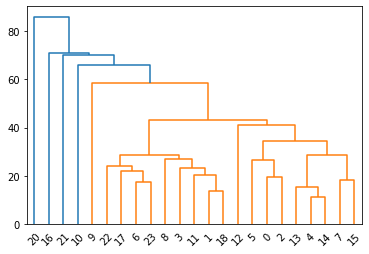

In [46]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
fig = plt.figure()
dendrogram(linkage, labels=labels)
plt.show()